In [1]:
# ==== 1. Gerekli Kütüphanelerin Yüklenmesi ====

!pip install openpyxl scikit-learn matplotlib seaborn --quiet

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


In [2]:
# ==== 2. Veri Setinin Yüklenmesi (Colab upload) ====

from google.colab import files
import io

uploaded = files.upload()  # Burada Online Retail.xlsx dosyanı seç

file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

df.head(), df.info()


Saving Online Retail.xlsx to Online Retail.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
 3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  ,
 None)

In [3]:
# ==== 3. Veri Temizleme ve Toplam Tutar Hesaplama ====

# Tarihi datetime formatına çevir
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# CustomerID boş olanları çıkar
df = df.dropna(subset=['CustomerID'])

# InvoiceNo'yu string yap (C ile başlayan iptalleri yakalamak için)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# İptal/iade faturaları çıkar (InvoiceNo 'C' ile başlıyorsa)
df = df[~df['InvoiceNo'].str.startswith('C')]

# Negatif veya sıfır miktar/fiyatları çıkar
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Toplam tutar hesapla
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Temizlenmiş satır sayısı:", len(df))
df.head()


Temizlenmiş satır sayısı: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# ==== 4. RFM Özelliklerinin Hesaplanması ====

# Referans tarih: veri setindeki en son işlem tarihinin 1 gün sonrası
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Referans tarih:", ref_date)

# RFM hesaplama
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency: son alışverişten beri geçen gün
    'InvoiceNo': 'nunique',                               # Frequency: fatura sayısı
    'TotalPrice': 'sum'                                   # Monetary: toplam harcama
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("Müşteri sayısı:", rfm.shape[0])
rfm.describe()


Referans tarih: 2011-12-10 12:50:00
Müşteri sayısı: 4338


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [5]:
# ==== 5. RFM Değerlerinin Ölçeklenmesi ====

X = rfm[['Recency', 'Frequency', 'Monetary']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]
# karşılaştırmak ve analiz edilebilir hale getirmek

array([[ 2.33457414, -0.4250965 ,  8.35866818],
       [-0.90534032,  0.3544168 ,  0.25096626],
       [-0.17535959, -0.03533985, -0.02859601],
       [-0.73534481, -0.4250965 , -0.0330118 ],
       [ 2.17457836, -0.4250965 , -0.19134727]])

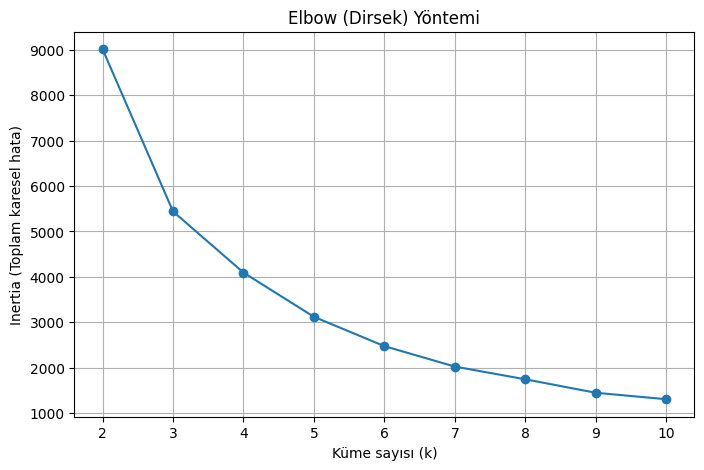

In [6]:
# ==== 6. Elbow (Dirsek) Yöntemi ile k Tahmini ====

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
# küme sayısını belirlemek için
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Küme sayısı (k)')
plt.ylabel('Inertia (Toplam karesel hata)')
plt.title('Elbow (Dirsek) Yöntemi')
plt.grid(True)
plt.show()


Silhouette skorları: {2: np.float64(0.8958167182320717), 3: np.float64(0.5941879366550106), 4: np.float64(0.6162128467651918), 5: np.float64(0.6165231087744963), 6: np.float64(0.5963168804095496), 7: np.float64(0.5164702399121813), 8: np.float64(0.5174591797377505), 9: np.float64(0.47773236230395444), 10: np.float64(0.42714342150727336)}


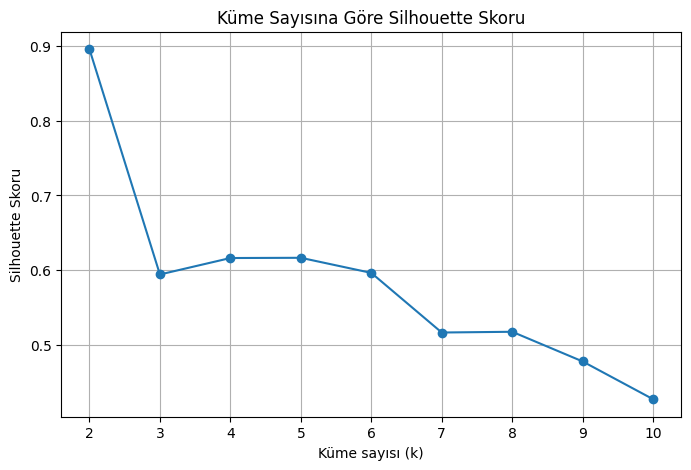

In [7]:
# ==== 7. Silhouette Skoru ile k Değerlendirme ====

sil_scores = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels, sample_size=10000, random_state=42)
    sil_scores[k] = score

print("Silhouette skorları:", sil_scores)
# küme sayısına göre silhouette.
plt.figure(figsize=(8,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel('Küme sayısı (k)')
plt.ylabel('Silhouette Skoru')
plt.title('Küme Sayısına Göre Silhouette Skoru')
plt.grid(True)
plt.show()


In [8]:
# ==== 8. Nihai K-Means Modeli (k = 4) ve Küme Ataması ====

best_k = 4  # Elbow + Silhouette'ten seçtiğin değer

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# RFM tablosuna Cluster sütunu ekle
rfm['Cluster'] = cluster_labels

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


In [9]:
# ==== KÜME BAZINDA HARCADIKLARI TUTARLAR ====

cluster_revenue = rfm.groupby('Cluster').agg(
    CustomerCount = ('Monetary', 'count'),
    TotalRevenue  = ('Monetary', 'sum'),
    AvgRevenue    = ('Monetary', 'mean')
)

# Toplam cirodan aldıkları pay
cluster_revenue['RevenueShare_%'] = 100 * cluster_revenue['TotalRevenue'] / cluster_revenue['TotalRevenue'].sum()

cluster_revenue

,CustomerCount,TotalRevenue,AvgRevenue,RevenueShare_%
Cluster,,,,
0,3054,4150536.513,1359.049284,46.575542
1,1067,512818.851,480.617480,5.754633
2,13,1655398.080,127338.313846,18.576168
3,204,2592654.460,12709.090490,29.093657


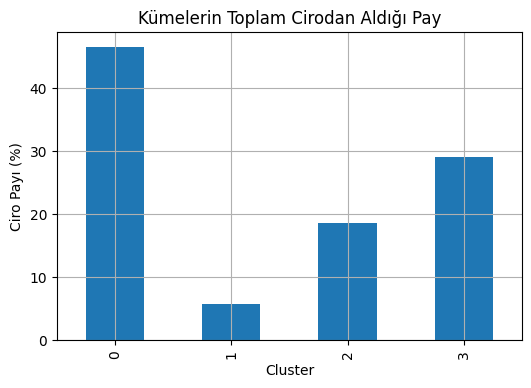

In [10]:
plt.figure(figsize=(6,4))
cluster_revenue['RevenueShare_%'].plot(kind='bar')
plt.ylabel('Ciro Payı (%)')
plt.xlabel('Cluster')
plt.title('Kümelerin Toplam Cirodan Aldığı Pay')
plt.grid(True)
plt.show()

In [11]:
# ==== 9. Kümeleme Kalitesi ve Küme Profilleri ====

final_sil_score = silhouette_score(X_scaled, cluster_labels, sample_size=10000, random_state=42)
print("Seçilen model için Silhouette Skoru:", final_sil_score)

# Her kümenin RFM ortalamaları
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
})

cluster_profile


Seçilen model için Silhouette Skoru: 0.6162128467651918


Recency         Frequency              Monetary                  
               mean median       mean median           mean      median count
Cluster                                                                      
0         43.702685   32.0   3.682711    3.0    1359.049284     829.295  3054
1        248.075914  243.0   1.552015    1.0     480.617480     310.470  1067
2          7.384615    2.0  82.538462   63.0  127338.313846  117379.630    13
3         15.500000    5.0  22.333333   19.0   12709.090490    8037.730   204

In [12]:
# ==== 10. Random Forest ile Cluster Tahmin Modeli (Supervised) ====
# kümeleme ile elde edilen müşteri segmentlerinin ne kadar anlamlıo ve ayırt edilebilir olduğunu test etmek için
#
# Özellikler (X) ve hedef (y)
X_rf = rfm[['Recency', 'Frequency', 'Monetary']].copy()
y_rf = rfm['Cluster'].copy()

# Eğitim / test ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.2,
    random_state=42,
    stratify=y_rf
)

print("Eğitim şekli:", X_train.shape, " Test şekli:", X_test.shape)

# Random Forest sınıflandırıcısı
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# Modeli eğit
rf.fit(X_train, y_train)

# Test setinde tahmin
y_pred = rf.predict(X_test)

# Doğruluk oranı
acc = accuracy_score(y_test, y_pred)
print("Random Forest Test Accuracy (Doğruluk Oranı):", acc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Eğitim şekli: (3470, 3)  Test şekli: (868, 3)
Random Forest Test Accuracy (Doğruluk Oranı): 0.9942396313364056

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       611
           1       1.00      1.00      1.00       213
           2       0.00      0.00      0.00         3
           3       0.91      0.98      0.94        41

    accuracy                           0.99       868
   macro avg       0.73      0.74      0.73       868
weighted avg       0.99      0.99      0.99       868



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recency: 0.743
Frequency: 0.158
Monetary: 0.099


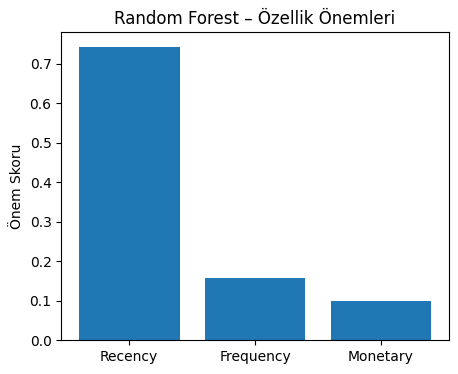

In [13]:
# ==== 12. Random Forest – Özellik Önemleri ====

feature_names = X_rf.columns
importances = rf.feature_importances_

for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.3f}")

plt.figure(figsize=(5,4))
plt.bar(feature_names, importances)
plt.title("Random Forest – Özellik Önemleri")
plt.ylabel("Önem Skoru")
plt.show()



📊 RFM DAĞILIM GRAFİKLERİ


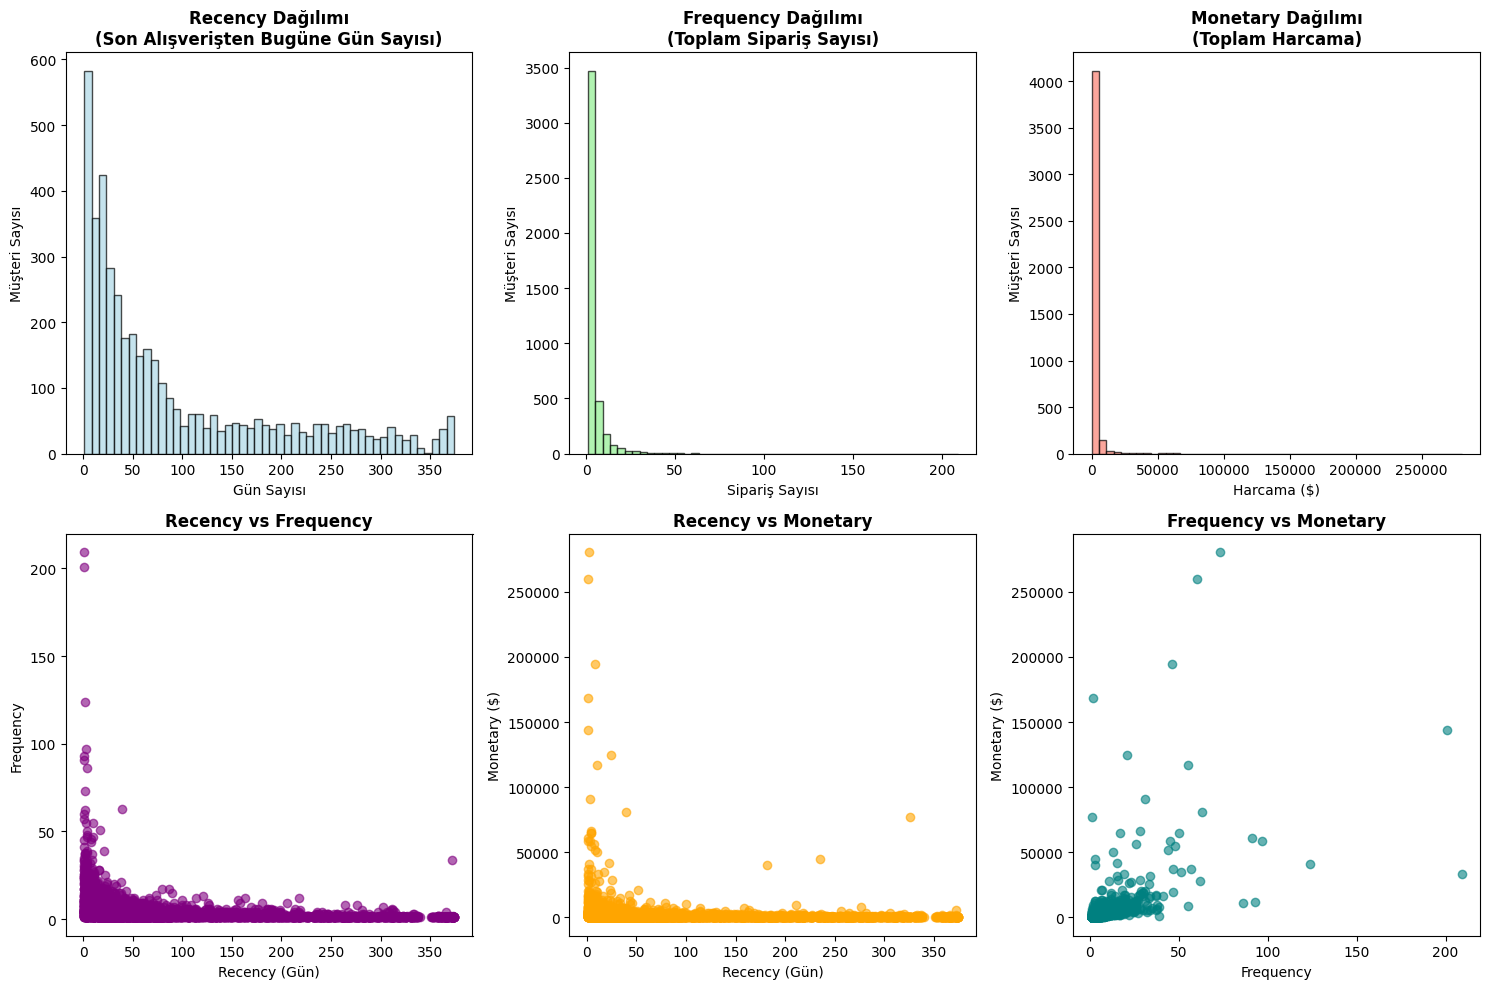

In [14]:
# 10. RFM DAĞILIM GÖRSELLEŞTİRMELERİ
print("\n📊 RFM DAĞILIM GRAFİKLERİ")
print("=" * 50)

plt.figure(figsize=(15, 10))

# Recency dağılımı
plt.subplot(2, 3, 1)
plt.hist(rfm['Recency'], bins=50, color='lightblue', alpha=0.7, edgecolor='black')
plt.title('Recency Dağılımı\n(Son Alışverişten Bugüne Gün Sayısı)', fontweight='bold')
plt.xlabel('Gün Sayısı')
plt.ylabel('Müşteri Sayısı')

# Frequency dağılımı
plt.subplot(2, 3, 2)
plt.hist(rfm['Frequency'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Frequency Dağılımı\n(Toplam Sipariş Sayısı)', fontweight='bold')
plt.xlabel('Sipariş Sayısı')
plt.ylabel('Müşteri Sayısı')

# Monetary dağılımı
plt.subplot(2, 3, 3)
plt.hist(rfm['Monetary'], bins=50, color='salmon', alpha=0.7, edgecolor='black')
plt.title('Monetary Dağılımı\n(Toplam Harcama)', fontweight='bold')
plt.xlabel('Harcama ($)')
plt.ylabel('Müşteri Sayısı')

# Recency - Frequency scatter
plt.subplot(2, 3, 4)
plt.scatter(rfm['Recency'], rfm['Frequency'], alpha=0.6, color='purple')
plt.title('Recency vs Frequency', fontweight='bold')
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency')

# Recency - Monetary scatter
plt.subplot(2, 3, 5)
plt.scatter(rfm['Recency'], rfm['Monetary'], alpha=0.6, color='orange')
plt.title('Recency vs Monetary', fontweight='bold')
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary ($)')

# Frequency - Monetary scatter
plt.subplot(2, 3, 6)
plt.scatter(rfm['Frequency'], rfm['Monetary'], alpha=0.6, color='teal')
plt.title('Frequency vs Monetary', fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')

plt.tight_layout()
plt.show()


📊 GÖRSELLEŞTİRMELER


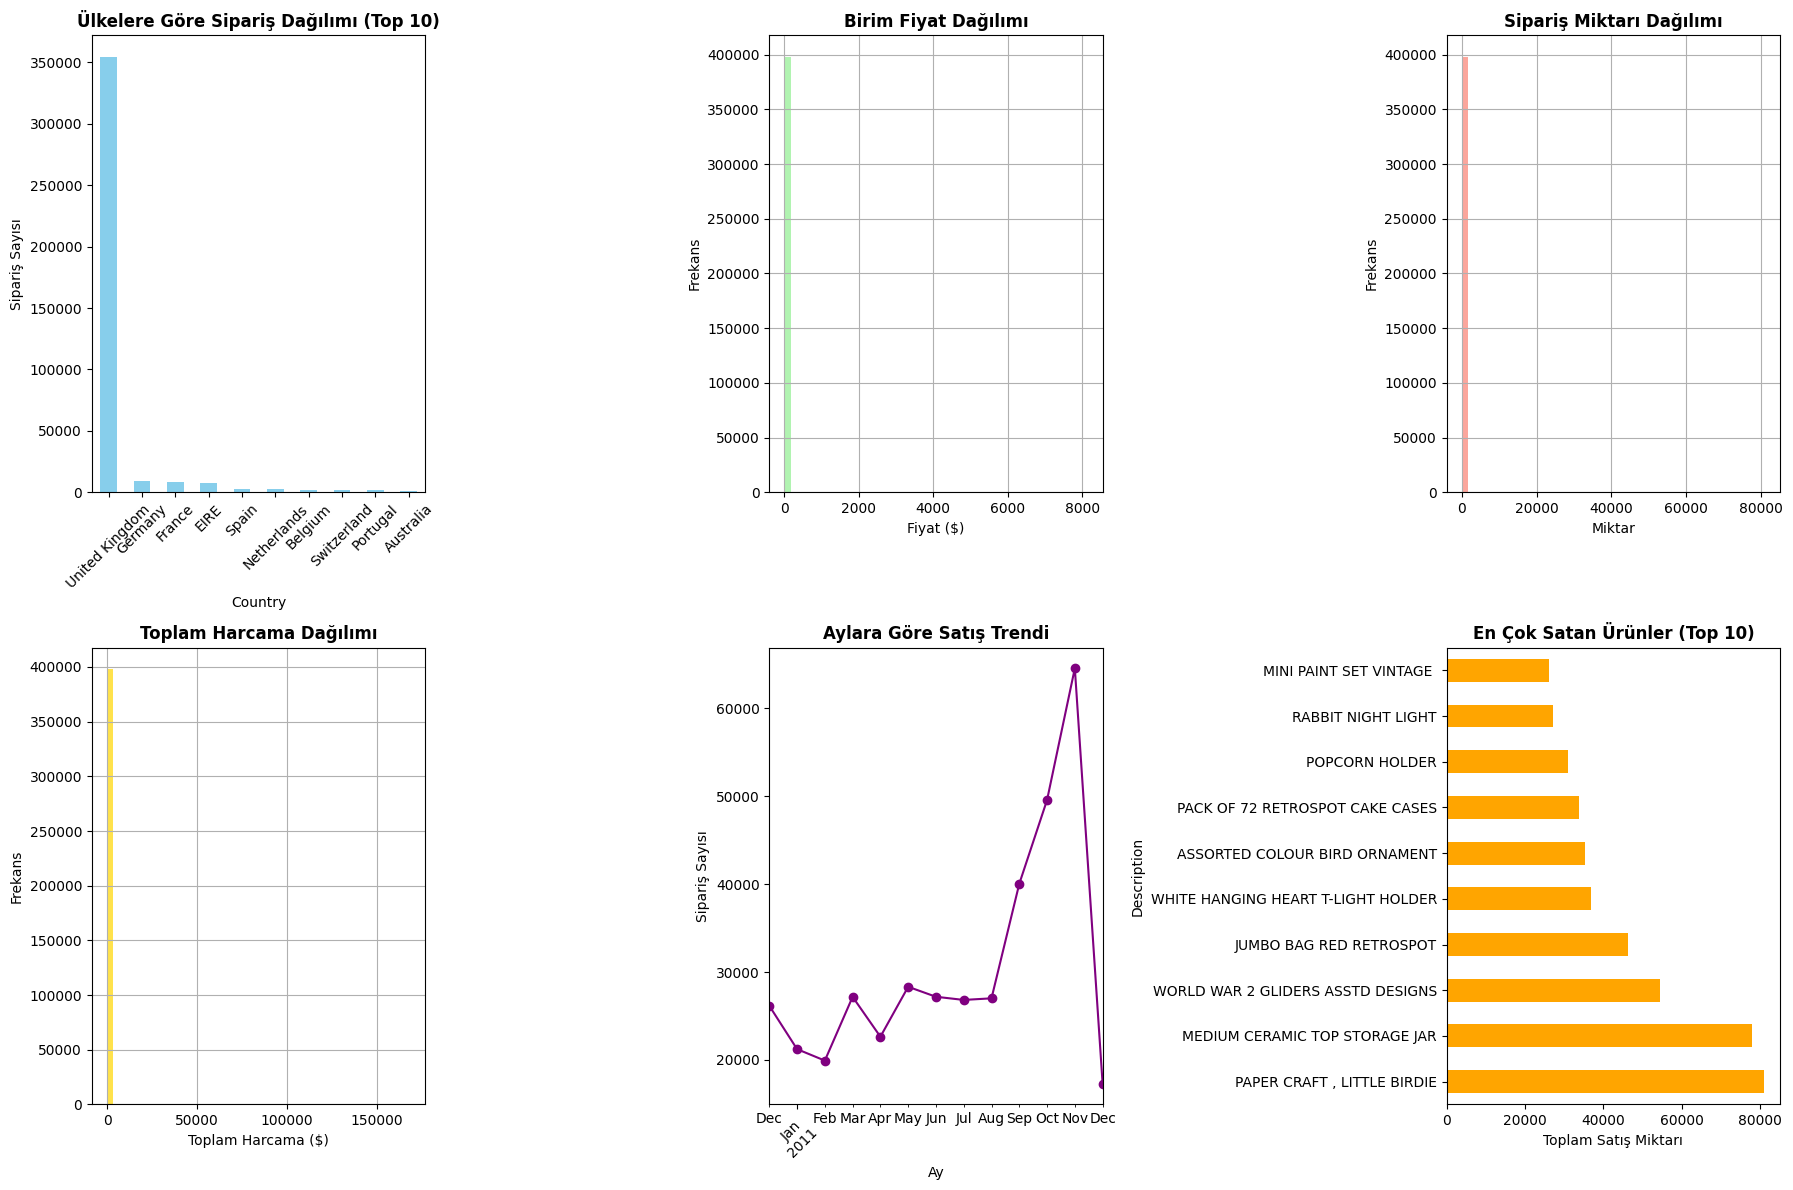

In [15]:
# 6. GÖRSELLEŞTİRMELER
print("\n📊 GÖRSELLEŞTİRMELER")
print("=" * 40)

plt.figure(figsize=(18, 12))

# 1. Ülkelere göre dağılım
plt.subplot(2, 3, 1)
country_counts = df['Country'].value_counts().head(10)
country_counts.plot(kind='bar', color='skyblue')
plt.title('Ülkelere Göre Sipariş Dağılımı (Top 10)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Sipariş Sayısı')

# 2. Birim fiyat dağılımı
plt.subplot(2, 3, 2)
df['UnitPrice'].hist(bins=50, color='lightgreen', alpha=0.7)
plt.title('Birim Fiyat Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Fiyat ($)')
plt.ylabel('Frekans')

# 3. Sipariş miktarı dağılımı
plt.subplot(2, 3, 3)
df['Quantity'].hist(bins=50, color='salmon', alpha=0.7)
plt.title('Sipariş Miktarı Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Miktar')
plt.ylabel('Frekans')

# 4. Toplam harcama dağılımı
plt.subplot(2, 3, 4)
df['TotalPrice'].hist(bins=50, color='gold', alpha=0.7)
plt.title('Toplam Harcama Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Toplam Harcama ($)')
plt.ylabel('Frekans')

# 5. Aylara göre satışlar
plt.subplot(2, 3, 5)
df['InvoiceDate'].dt.to_period('M').value_counts().sort_index().plot(kind='line', color='purple', marker='o')
plt.title('Aylara Göre Satış Trendi', fontsize=12, fontweight='bold')
plt.xlabel('Ay')
plt.ylabel('Sipariş Sayısı')
plt.xticks(rotation=45)

# 6. En çok satan ürünler (top 10)
plt.subplot(2, 3, 6)
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', color='orange')
plt.title('En Çok Satan Ürünler (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Toplam Satış Miktarı')

plt.tight_layout()
plt.show()

In [16]:
# 7. EK ANALİZLER
print("\n📈 EK ANALİZLER")
print("=" * 40)

# En değerli müşteriler
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("\n🏆 EN DEĞERLİ 10 MÜŞTERİ:")
for i, (cust_id, revenue) in enumerate(top_customers.items(), 1):
    print(f"{i}. Müşteri {cust_id}: ${revenue:,.2f}")

# Ortalama değerler
avg_order_value = df['TotalPrice'].mean()
avg_quantity = df['Quantity'].mean()
print(f"\n📊 Ortalama Sipariş Değeri: ${avg_order_value:.2f}")
print(f"📦 Ortalama Sipariş Miktarı: {avg_quantity:.1f}")


📈 EK ANALİZLER

🏆 EN DEĞERLİ 10 MÜŞTERİ:
1. Müşteri 14646.0: $280,206.02
2. Müşteri 18102.0: $259,657.30
3. Müşteri 17450.0: $194,550.79
4. Müşteri 16446.0: $168,472.50
5. Müşteri 14911.0: $143,825.06
6. Müşteri 12415.0: $124,914.53
7. Müşteri 14156.0: $117,379.63
8. Müşteri 17511.0: $91,062.38
9. Müşteri 16029.0: $81,024.84
10. Müşteri 12346.0: $77,183.60

📊 Ortalama Sipariş Değeri: $22.40
📦 Ortalama Sipariş Miktarı: 13.0



📊 KÜME GÖRSELLEŞTİRMELERİ


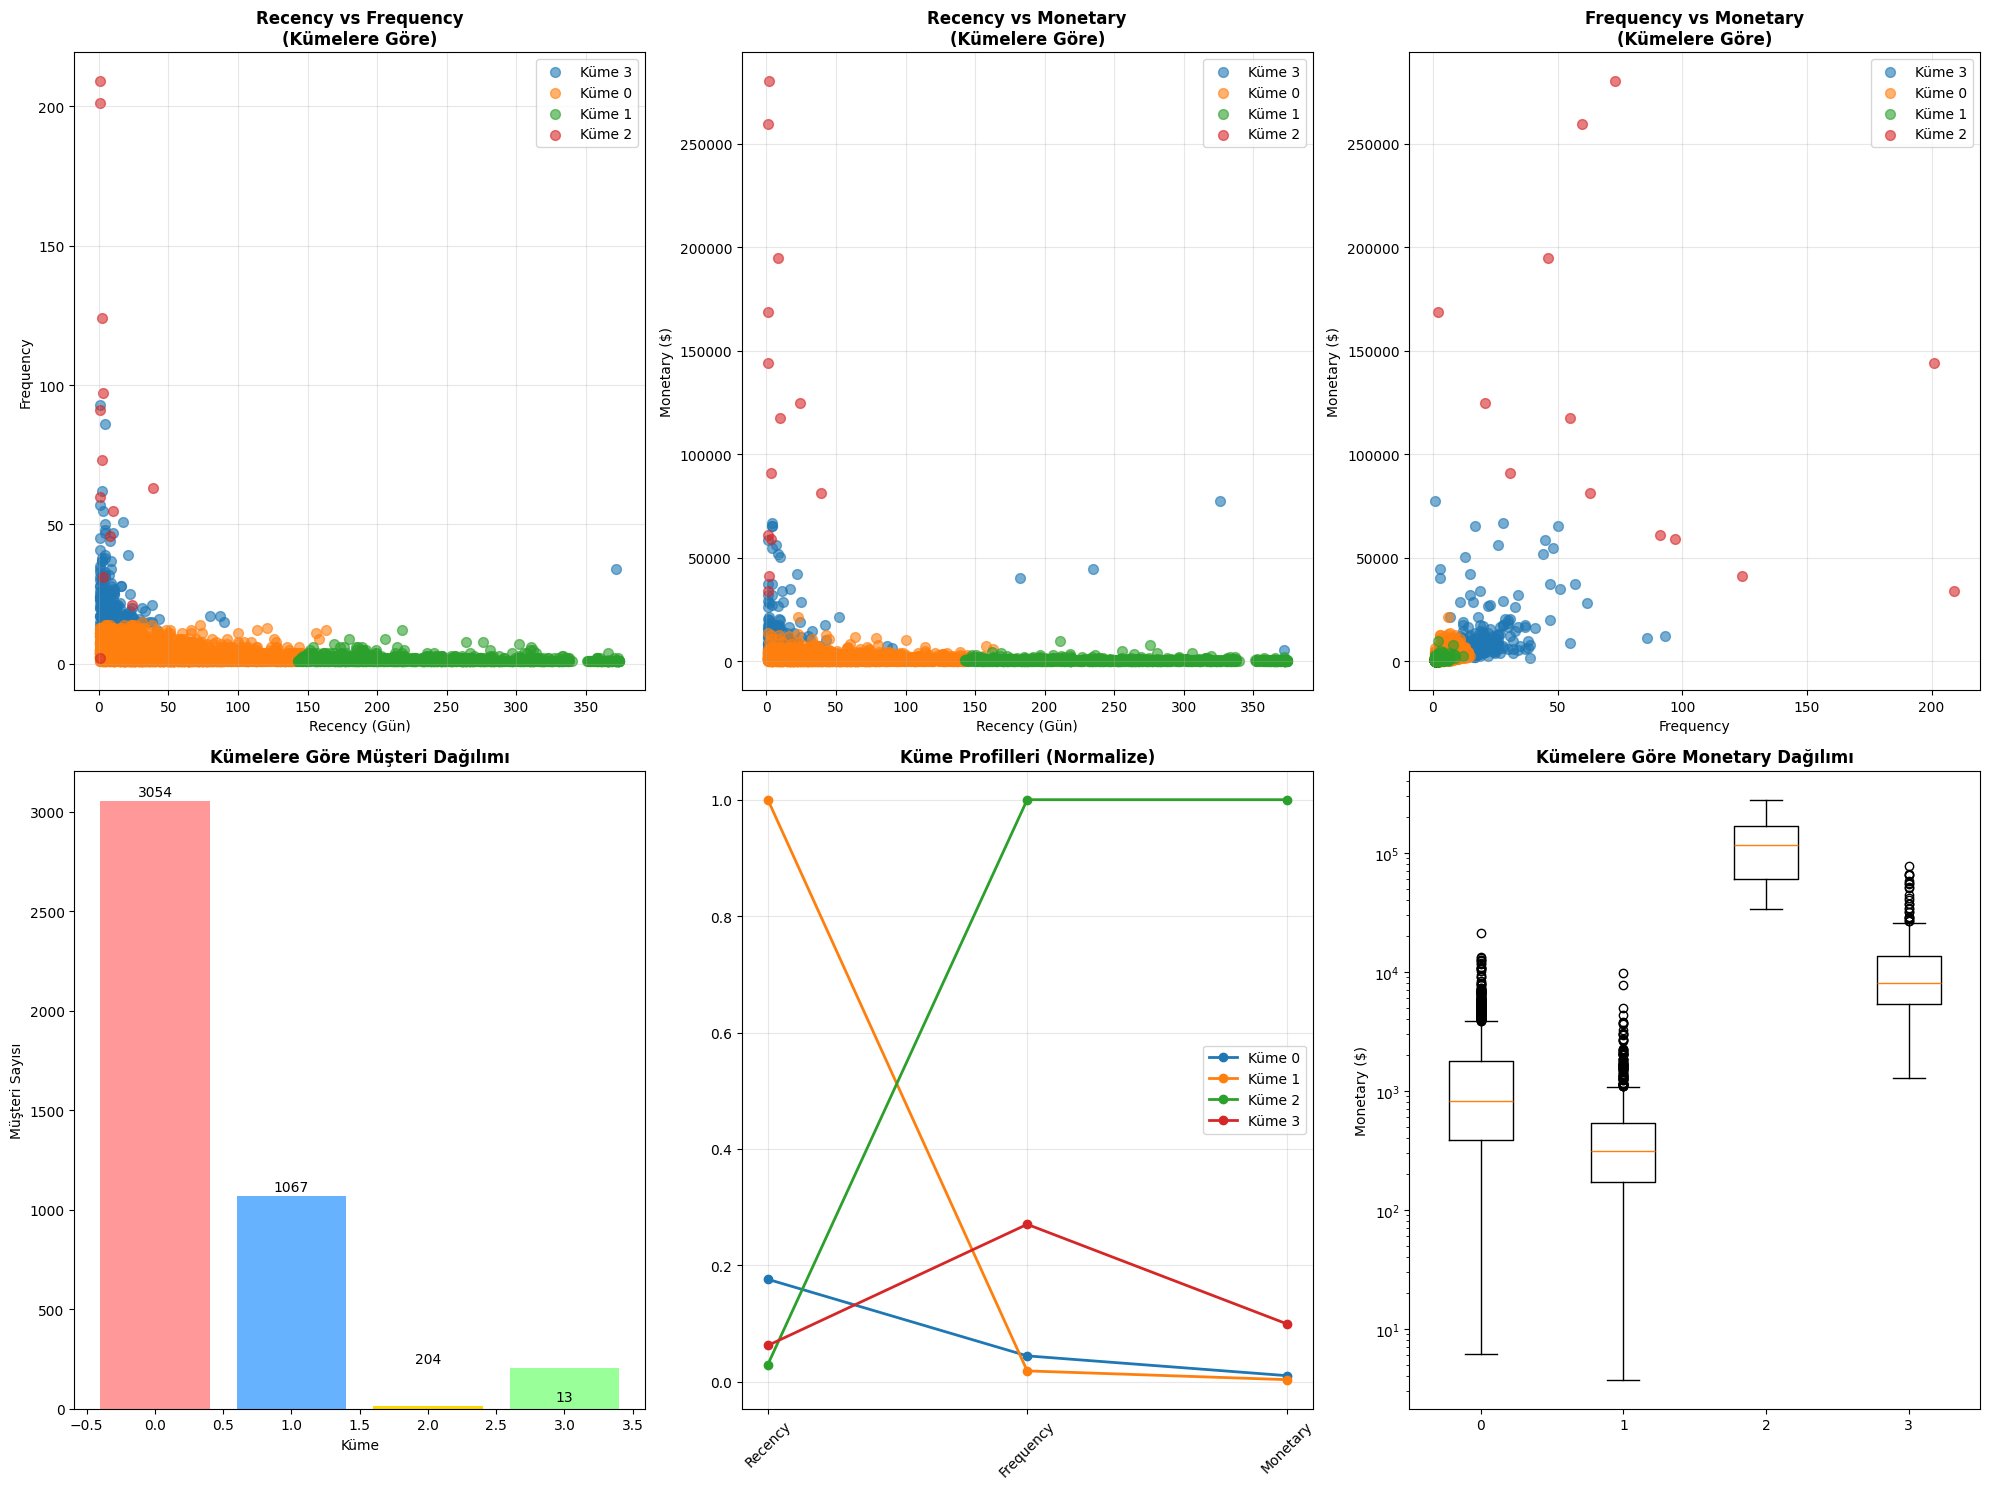

In [17]:
# 18. KÜME GÖRSELLEŞTİRMELERİ
print("\n📊 KÜME GÖRSELLEŞTİRMELERİ")
print("=" * 50)

plt.figure(figsize=(20, 15))

# 1. Recency vs Frequency
plt.subplot(2, 3, 1)
for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Frequency'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Recency vs Monetary
plt.subplot(2, 3, 2)
for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Frequency vs Monetary
plt.subplot(2, 3, 3)
for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    plt.scatter(cluster_data['Frequency'], cluster_data['Monetary'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')
plt.title('Frequency vs Monetary\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Küme dağılımı - Bar chart
plt.subplot(2, 3, 4)
cluster_counts = rfm['Cluster'].value_counts()
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700']
plt.bar(cluster_counts.index, cluster_counts.values, color=colors[:len(cluster_counts)])
plt.xlabel('Küme')
plt.ylabel('Müşteri Sayısı')
plt.title('Kümelere Göre Müşteri Dağılımı', fontweight='bold')
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

# 5. Ortalama değerler - Radar chart hazırlığı
plt.subplot(2, 3, 5)
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize et (0-1 arası)
cluster_means_normalized = cluster_means / cluster_means.max()

for cluster in cluster_means_normalized.index:
    values = cluster_means_normalized.loc[cluster].values
    plt.plot(['Recency', 'Frequency', 'Monetary'], values,
             marker='o', label=f'Küme {cluster}', linewidth=2)
plt.title('Küme Profilleri (Normalize)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 6. Monetary dağılımı - Box plot
plt.subplot(2, 3, 6)
box_data = [rfm[rfm['Cluster'] == cluster]['Monetary'] for cluster in sorted(rfm['Cluster'].unique())]
plt.boxplot(box_data, tick_labels=sorted(rfm['Cluster'].unique()))
plt.ylabel('Monetary ($)')
plt.title('Kümelere Göre Monetary Dağılımı', fontweight='bold')
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

In [18]:
# 22. GELİR ANALİZİ
print("\n💰 GELİR ANALİZİ")
print("=" * 50)

# Küme bazlı gelir analizi
revenue_by_cluster = rfm.groupby('Cluster')['Monetary'].agg(['sum', 'mean', 'count'])
revenue_by_cluster['percentage_of_total'] = (revenue_by_cluster['sum'] / revenue_by_cluster['sum'].sum()) * 100
revenue_by_cluster['revenue_per_customer'] = revenue_by_cluster['sum'] / revenue_by_cluster['count']

print("📊 KÜME BAZLI GELİR ANALİZİ:")
display(revenue_by_cluster.round(2))

# Toplam gelir
total_revenue = revenue_by_cluster['sum'].sum()
print(f"\n💰 TOPLAM GELİR: ${total_revenue:,.2f}")

# En değerli küme
most_valuable_cluster = revenue_by_cluster['sum'].idxmax()
most_valuable_revenue = revenue_by_cluster.loc[most_valuable_cluster, 'sum']
print(f"🏆 EN DEĞERLİ KÜME: {most_valuable_cluster} (${most_valuable_revenue:,.2f})")

# Pareto analizi (80-20 kuralı)
print(f"\n📈 PARETO ANALİZİ:")
sorted_revenue = revenue_by_cluster['sum'].sort_values(ascending=False)
cumulative_percentage = sorted_revenue.cumsum() / total_revenue * 100

for cluster, cum_pct in cumulative_percentage.items():
    print(f"Küme {cluster} dahil: Toplam gelirin {cum_pct:.1f}%'ı")


💰 GELİR ANALİZİ
📊 KÜME BAZLI GELİR ANALİZİ:


,sum,mean,count,percentage_of_total,revenue_per_customer
Cluster,,,,,
0,4150536.51,1359.05,3054,46.58,1359.05
1,512818.85,480.62,1067,5.75,480.62
2,1655398.08,127338.31,13,18.58,127338.31
3,2592654.46,12709.09,204,29.09,12709.09



💰 TOPLAM GELİR: $8,911,407.90
🏆 EN DEĞERLİ KÜME: 0 ($4,150,536.51)

📈 PARETO ANALİZİ:
Küme 0 dahil: Toplam gelirin 46.6%'ı
Küme 3 dahil: Toplam gelirin 75.7%'ı
Küme 2 dahil: Toplam gelirin 94.2%'ı
Küme 1 dahil: Toplam gelirin 100.0%'ı


In [27]:
# 1. Ortalamaları Hazırlayalım
segment_analizi = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Kişi Sayısı'}).round(1)

# EŞİK DEĞERLERİ İÇİN MEDYAN KULLANALIM (Uç değerlerden etkilenmemek için)
m_median = segment_analizi['Monetary'].median()
r_median = segment_analizi['Recency'].median()

def segment_yorumu_yap(row, analysis_df):
    m_max = analysis_df['Monetary'].max()
    r_max = analysis_df['Recency'].max()

    # 1. VIP
    if row['Monetary'] == m_max:
        return "ŞAMPİYONLAR (VIP)", "En değerli ve sadık kitle."

    # 2. CHURN
    elif row['Recency'] == r_max:
        return "KAYIP RİSKİ TAŞIYANLAR / YENİDEN KAZANILACAKLAR", "Marka hafızasından silinmek üzereler. Re-aktivasyon şart."

    # 3. YÜKSEK DEĞERLİ / SADIK (Küme 3 buraya girecek)
    # Harcaması medyanın üstünde ve yakın zamanda gelmiş
    elif row['Monetary'] >= m_median and row['Recency'] < r_median:
        return "SADIK MÜŞTERİLER", "Harcama gücü yüksek ve aktif grup."

    # 4. POTANSİYEL / YENİ (Küme 0 buraya girecek)
    # Harcaması düşük ama son gelişi nispeten yakın
    elif row['Monetary'] < m_median and row['Recency'] < r_median:
        return "POTANSİYEL MÜŞTERİLER", "Yeni/Küçük harcamalı. Alışkanlık kazandırılmalı."

    # 5. DİĞER
    else:
        return "DİKKAT EDİLMESİ GEREKEN", "Ortalama performans sergileyen grup."

# Sonuç Yazdırma
for cluster_id, row in segment_analizi.iterrows():
    isim, strateji = segment_yorumu_yap(row, segment_analizi)
    print(f"\n[{cluster_id}. KÜME] -> TANIM: {isim}")
    print(f"   • Ortalama Harcama: {row['Monetary']} birim")
    print(f"   • Son Ziyaret: {row['Recency']} gün önce")
    print(f"   • Müşteri Sayısı: {int(row['Kişi Sayısı'])}")
    print(f"   -> TAVSİYE: {strateji}")

    if "ŞAMPİYON" in isim:
        print("   -> AKSİYON: VIP destek, öncelikli gönderim ve özel hediyeler.")
    elif "SADIK" in isim:
        print("   -> AKSİYON: Çapraz satış (cross-sell) ve yeni koleksiyon tanıtımı.")
    elif "POTANSİYEL" in isim:
        print("   -> AKSİYON: Sepet alt limitiyle çalışan indirim çekleri.")
    elif "DİKKAT" in isim:
        print("   -> AKSİYON: Hatırlatıcı e-postalar ve memnuniyet anketleri.")
    elif "KAYIP" in isim:
        print("   -> AKSİYON: 'Seni Özledik' anketi ile neden gittiklerini sorun. "
              "Geri dönmeleri için 'sadece sana özel' tanımlı ve kısa süreli "
              "(48 saatlik) bir 'uyandırma kuponu' gönderin.")


[0. KÜME] -> TANIM: DİKKAT EDİLMESİ GEREKEN
   • Ortalama Harcama: 1359.0 birim
   • Son Ziyaret: 43.7 gün önce
   • Müşteri Sayısı: 3054
   -> TAVSİYE: Ortalama performans sergileyen grup.
   -> AKSİYON: Hatırlatıcı e-postalar ve memnuniyet anketleri.

[1. KÜME] -> TANIM: KAYIP RİSKİ TAŞIYANLAR / YENİDEN KAZANILACAKLAR
   • Ortalama Harcama: 480.6 birim
   • Son Ziyaret: 248.1 gün önce
   • Müşteri Sayısı: 1067
   -> TAVSİYE: Marka hafızasından silinmek üzereler. Re-aktivasyon şart.
   -> AKSİYON: 'Seni Özledik' anketi ile neden gittiklerini sorun. Geri dönmeleri için 'sadece sana özel' tanımlı ve kısa süreli (48 saatlik) bir 'uyandırma kuponu' gönderin.

[2. KÜME] -> TANIM: ŞAMPİYONLAR (VIP)
   • Ortalama Harcama: 127338.3 birim
   • Son Ziyaret: 7.4 gün önce
   • Müşteri Sayısı: 13
   -> TAVSİYE: En değerli ve sadık kitle.
   -> AKSİYON: VIP destek, öncelikli gönderim ve özel hediyeler.

[3. KÜME] -> TANIM: SADIK MÜŞTERİLER
   • Ortalama Harcama: 12709.1 birim
   • Son Ziyaret: 15.